# Task 7: Discretising the Map and Finding Optimal Paths

In this notbook, we will create a (discretised) representation of the robot's internal map and use it to plan a path from one point to another while avoiding some obstacles.

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Creating the discretised map

So far, our representation of the world only consists of a set of markers and their positions, and is only implicitly provided by the our SLAM implementation. This way of representing the world is however inconvenient for more complex tasks like path planning. Thus, we want to 

**Task:** Create a map that represents the robot's environment, and  that can later be used to do path planning. Think about how you should represent markers or other obstacles in the map. Think about how you can make sure that the robot, when following a planned path later on, stays far enough away from them while driving.

In [2]:
### Your code here ###
map_size = 4
marker_size = 0.068
step_size = 0.01
Map = np.zeros((int(map_size / step_size), int(map_size / step_size)))
###

**Task:** Write a function that projects from the robot's world frame coordinates to your map coordinates, and a function that projects map coordinates back into world frame coordinates.

**Note:** If the coordinate frame in your map implementation is identical to the robot's world coordinate frame, feel free to just ignore these functions.

In [11]:
### Your code here ###
def world_to_map(pos,step_size,map_size):
    pos += map_size / 2

    return np.round(pos / step_size).astype(int)

def map_to_world(pos):
    pos -= int(map_size / (2 * step_size))

    return pos * step_size
###

**Task:** Write a function that adds a marker with given coordinates to your map. 

In [4]:
### Your code here ###
def add_marker(Map, pos, marker_size):
    x, y = world_to_map(pos)
    ms = int(marker_size / step_size)
    
    Map[y-ms:y+ms, x-ms:x+ms] = 1

###

Our robot has detected a number of markers in its environment, so we can now get their coordinates, poses and ids from SLAM.

In [5]:
markers_slam = (np.array([[ 0.35988178,  0.03438656],
            [ 0.47746729, -0.09735373],
            [ 0.59155068,  0.01508132]]),
     np.array([[ 0.00243039,  0.00058545,  0.10204815],
            [ 0.00414831,  0.001392  , -0.20395623],
            [ 0.00306644,  0.00126878,  0.04704469]]),
     np.array([821, 902, 557]))

coords, poses, ids = markers_slam

**Task:** Add all markers to the map.

In [6]:
### Your code here ###
for coord in coords:
    add_marker(Map, coord, marker_size)
###

**Task:** Visualise your map with the added markers.

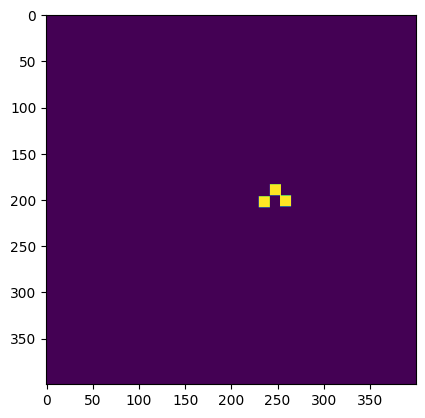

In [7]:
### Your code here
plt.imshow(Map)
###

## Path planning

At the core of many planning tasks (especially the ones in our project) is pathfinding. In the following section, we use our map to plan a(n optimal) path from one point to another, while avoiding the markers that are in between the two points.

**Task:** Implement a pathfinding algorithm (e.g. A*) that can be used by the robot to find paths between points in your map.

In [ ]:
### Your code here ###
#Map = np.zeros((10, 10))
#Map[3:5, 3:6] = 1   

def find_path(M, start, goal):
    G = np.full(Map.shape, np.inf, dtype=float)
    
    # pre compute all values for H
    i, j = Map.shape
    ii, jj = np.meshgrid(np.arange(i), np.arange(j))
    
    # saves x and y distances seperately to compute grid distance
    distances = np.abs([ii - goal[0], jj - goal[1]])
    d_max = np.max(distances, axis=0).T
    d_min = np.min(distances, axis=0).T
    H = (d_max - d_min) * 10 + d_min * 14

    # saves positions of obstacles and already known nodes
    # init as copy of map to exlude obstacle nodes from pathfinding
    mask = np.array(Map, dtype=bool)
    F = np.ma.MaskedArray(G + H, mask)

    # for every discovered node save where optimal path came from
    pred = np.zeros((i, j, 2), dtype=int)
    
    x, y = start
    G[x, y] = 0

    neighbours = lambda x, y: np.array([
        [x, y + 1],
        [x, y - 1], 
        [x - 1, y], 
        [x + 1, y], 
        [x - 1, y - 1],
        [x - 1, y + 1],
        [x + 1, y - 1],
        [x + 1, y + 1]
    ])
    
    while np.any((x, y) != goal):
        Gc = G[x, y]
        mask[x, y] = 1
        
        for num, (nx, ny) in enumerate(neighbours(x, y)):  
            if not mask[nx, ny]:
                # diagonal neighbour distance is 14 instead of 10
                d = 14 if num > 3 else 10

                if Gc + d < G[nx, ny]:
                    G[nx, ny] = Gc + d
                    pred[nx, ny] = (x, y)
    
                F[nx, ny] = G[nx, ny] + H[nx, ny]
        
        # Search for min F chordinates
        F_min = np.min(F)
        min_idxs = np.where(F.flatten() == F_min)[0]
        
        # Select min index based on smallest H value
        H_values = H.flatten()[min_idxs]
        min_idx = min_idxs[np.argmin(H_values)]
        
        x, y = np.unravel_index(min_idx, F.shape)

    # backtracking
    path = []
    while np.any((x, y) != start):
        path.append((x, y))
        x, y = pred[x, y]

    return np.array(path)
###

**Task:** Use your shortest path algorithm to find a path from the given start to end point.

In [9]:
start_point = np.array([0.1,0.3], dtype=float)
end_point = np.array([-0.1,0.6], dtype=float)
### Your code here ###
path = find_path(Map, world_to_map(start_point), world_to_map(end_point))
###

**Task:** Draw your path onto the map and display it. (Tipp: This might work easiest using a pyplot [scatter]plot)

(150.0, 250.0)

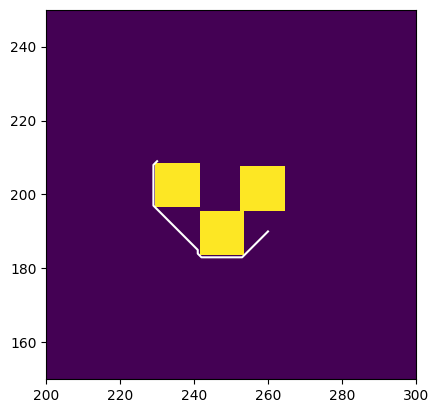

In [10]:
### Your code here ###
plt.imshow(Map)
plt.plot(path[:, 1], path[:, 0], c='white')
plt.xlim(200, 300)
plt.ylim(150, 250)
###

**Final Note:** Think about how the path your robot takes would look like in the real world. Would it be feasible for the real robot? A path that goes in between the markers, for example, would be impossible to use for the actual robot, because the markers are too close together for the actual robot to drive between them.